In [4]:
import sys
import numpy as np
import threading
import copy

global_state = (np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)

In [5]:
import sys
import numpy as np
import threading
import copy

n=20
current_state = copy.deepcopy(global_state)  # matrica stanja u formatu odgovarajucem za visualizer. pocetno stanje nasumicno generisemo, naredne iteracije ce ga menjati
states1 = [copy.deepcopy(current_state)]                                     # mozemo odmah sacuvati pocetno stanje u nizu stanja. tu cemo nakon svake iteracije dodavati najnovije stanje

reads = [0 for _ in range(n**2)]                                         # brojaci za citanja svake celije
reads_mutex = [threading.Lock() for _ in range(n**2)]                    # muteksi za sinhronizaciju suseda koji menjaju brojace citanja (tacka 1)
update_self = [threading.Semaphore(0) for _ in range(n**2)]              # semafori za budjenje celija za upis svog novog stanja (tacka 1)
total_updates = 0                                                        # brojac za sve celije koje su azurirale svoje stanje (tacka 3)
total_updates_mutex = threading.Lock()                                   # kljuc koji stiti brojac azuriranih celija (tacka 3)
next_iteration = threading.Condition()                                   # uslov za prelazak u sledecu iteraciju (tacka 2)

xx = [1, 1, 1, -1, -1, -1, 0, 0]                                # koordinate za pomeraj do svih 8 suseda
yy = [1, -1, 0, 1, -1, 0, 1, -1]

def live (tid, x, y, steps = 20):
    global total_updates
    for _ in range(steps):
        alive = 0                                                   # alive - brojac zivih suseda
        for move in range (8):                                      # prolazimo kroz sve susede
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                   # koordinate suseda mod-ujemo sa n zbog torus matrice (spojeni krajevi)
            alive += current_state[x1][y1]                            # dodajemo stanje suseda (0 ili 1) na brojac zivih suseda
            nid = x1*n + y1                                           # nid - neighbor id, cell id = x*20 + y da bismo dobili niz indeksa od 0 do 20^2
            reads_mutex[nid].acquire()                                # trazimo pristup za menjanje brojaca citanja te celije
            reads[nid] += 1
            if reads[nid] == 8:                                       # ako je to bio poslednji sused koji je procitao, budimo celiju da se azurira u matrici stanja
                update_self[nid].release()
            reads_mutex[nid].release()       
        cid = x*n+y
        update_self[cid].acquire()                               # kada je procitala susede celija moze da azurira svoje stanje, ali prvo ceka da svi susedi procitaju njeno trenutno stanje
        reads[cid] = 0                                           # resetuje brojac reads na 0 za sledecu iteraciju                                        
        if (alive < 2 or alive > 3):                             # azuriranje stanja celije u odnosu na uslove
            current_state[x][y] = 0
        elif alive == 3:
            current_state[x][y] = 1
        elif alive == 2 and current_state[x][y] == 1:            # ovde je ovo malo i bespotrebna linija jer ako alive = 2, celija ostaje na stanju na kom je bila
            current_state[x][y] = 1

        total_updates_mutex.acquire()                             # mutex za izmenu brojaca azuriranih celija
        total_updates += 1
        if (total_updates == n**2):                               # kada poslednja celija azurira svoje stanje, cuvamo kopiju stanja i sve niti koje su cekale mogu u sledecu iteraciju
            total_updates = 0
            states1.append(copy.deepcopy(current_state))
            total_updates_mutex.release()
            next_iteration.acquire()
            next_iteration.notify_all()
        else:                                                   
            total_updates_mutex.release()                           # ovde je vazno prvo osloboditi mutex za brojac azuriranih celija pa tek onda uci u stanje cekanja za pocetak sledece iteracije                                                          
            next_iteration.acquire()                                # da ne bi doslo do deadlock-a - nit ceka na uslov a drzi kljuc koji treba ostalim nitima da bi ostvarile taj uslov
            next_iteration.wait()
        next_iteration.release()


threads = []
for cid in range(n**2):
    threads.append(threading.Thread(target = live, args = (cid, cid//n, cid%n)))        # od cell id generisemo koordinate - row = index / columns_per_row, column = index % columns_per_row

for t in threads:
    t.start()
    
for t in threads:
    t.join()



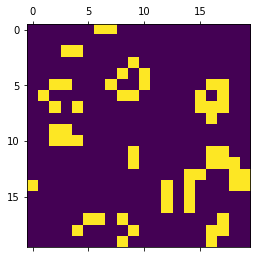

In [6]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states1);
HTML(anim.to_html5_video())

In [7]:
import sys
import numpy as np
import threading
import copy
from queue import Queue

n=20
steps = 20
start_state = copy.deepcopy(global_state)       
states2 = np.zeros(shape = (steps, n, n), dtype = np.int8)

queues = [Queue(8) for _ in range(n**2)]                        # redovi svake celije za stanja susednih celija         
cell_updated = Queue(n**2)                                      # red za kontroler thread koji signalira da je celija azurirala stanje i spremna za sledecu iteraciju
next_iteration = [Queue(1) for _ in range(n**2)]                # red za signal svakoj celiji da zapocne sledecu iteraciju

xx = [1, 1, 1, -1, -1, -1, 0, 0]                                
yy = [1, -1, 0, 1, -1, 0, 1, -1]

def control (tid, steps):                                       # funkcija za kontrolor thread
    for _ in range(steps):
        for i in range (n**2):                                      # ceka informaciju od svake celije da je spremna za sledecu iteraciju
            cell_updated.get()                                        # get - blokirajuci poziv, ova petlja ce se zavrsiti tek kada se sve celije upisu u queue
        for i in range (n**2):
            next_iteration[i].put(1)                                  # kada su sve spremne, javlja svakoj celiji da predju u sledecu iteraciju
      

def live (tid, x, y, state, steps):
    for step in range(steps):
        alive = 0     
        cid = x*n+y
        for move in range (8):                                  
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                 
            neighbor_id = x1*n + y1  
            queues[neighbor_id].put(state)                        # u queue svakog suseda celija upisuje svoje stanje
        for i in range (8):                                    
            alive += queues[cid].get()                            # zatim cita stanja suseda iz svog queue-a (sabira jedinice tj zive)
        if (alive < 2 or alive > 3):                           
            state = 0                                             
        elif alive == 3:
            state = 1
        elif alive == 2 and state == 1:
            state = 1
        else:
            state = 0
        states2[step][x][y] = state                            # upisuje svoj state u niz stanja kroz vreme, u trenutnu iteraciju i svoj indeks (nema sudaranja threadova)
        cell_updated.put(1)                                     # obavestava kontroler thread da je zavrsila azuriranje i spremna je za sledecu iteraciju
        next_iteration[cid].get()                               # get - blokirajuci poziv, ceka signal od kontrolera da sme da zapocne novu iteraciju


controller = threading.Thread(target = control, args = (n**2, steps))
threads = []
for i in range(n**2):
    x = i//n
    y = i%n
    threads.append(threading.Thread(target = live, args = (i, x, y, start_state[x][y], steps)))              # prosledjujemo svakom polju i njegovo pocetno stanje

controller.start()
for t in threads:
    t.start()

controller.join()
for t in threads:
    t.join()




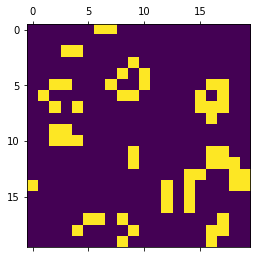

In [8]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states2);
HTML(anim.to_html5_video())

In [9]:
import sys
import numpy as np
import multiprocessing
import copy

def control (n, steps, cell_updated, next_iteration, conn):        # funkcija za kontrolor proces
    states3 = np.zeros(shape = (steps, n, n), dtype = np.int8)
    for _ in range(steps):
        for i in range (n**2):                                                      # ceka poruku sa azuriranim stanjem svake celije koja je spremna za sledecu iteraciju
            msg = cell_updated.get()                                                  # get - blokirajuci poziv, ova petlja ce se zavrsiti tek kada se sve celije upisu u queue
            states3[msg[0]][msg[1]][msg[2]] = msg[3]                                   # kada primi poruku azurira odredjeno polje u listi stanja
        for i in range (n**2):
            next_iteration[i].put(1)                                                  # kada su sve azurirane, javlja svakoj celiji da predje u sledecu iteraciju
    conn.send(states3)                                                             # na kraju putem pipe-a vraca listu stanja u main proces
      

def live (x, y, state, n, steps, queues, cell_updated, next_iteration):    # sve promenljive saljemo kao argumente - preporuka sa interneta
    for step in range(steps):
        alive = 0     
        cid = x*n+y
        for move in range (8):                                  
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                 
            neighbor_id = x1*n + y1  
            queues[neighbor_id].put(state)                                            # u queue svakog suseda celija upisuje svoje stanje
        for i in range (8):                                    
            alive += queues[cid].get()                                                # zatim cita stanja suseda iz svog queue-a (sabira zive)
        if (alive < 2 or alive > 3):                           
            state = 0                                             
        elif alive == 3:
            state = 1
        elif alive == 2 and state == 1:
            state = 1
        cell_updated.put((step, x, y, state))                   # salje kroz queue kontroler threadu poruku sa novim stanjem i spremna je za sledecu iteraciju
        next_iteration[cid].get()                               # get - blokirajuci poziv, ceka signal od kontrolera da sme da zapocne novu iteraciju


if __name__ == "__main__":
    n = 20
    steps = 20
    start_state = copy.deepcopy(global_state) 

    queues = [multiprocessing.JoinableQueue(8) for _ in range(n**2)]              # redovi svakog procesa za stanja susednih procesa        
    cell_updated = multiprocessing.JoinableQueue(n**2)                            # red kojim celije javljaju nova stanja kontroler threadu
    next_iteration = [multiprocessing.JoinableQueue(1) for _ in range(n**2)]    # redovi za signal svakoj celiji da zapocne sledecu iteraciju
    conn1, conn2 = multiprocessing.Pipe()                                         # pipe za komunikaciju glavnog procesa i kontrolor procesa  (za vracanje stanja)

    xx = [1, 1, 1, -1, -1, -1, 0, 0]                                
    yy = [1, -1, 0, 1, -1, 0, 1, -1]

    controller = multiprocessing.Process(target = control, args = (n, steps, cell_updated, next_iteration, conn1))
    processes = []
    for i in range(n**2):
        x = i//n
        y = i%n
        processes.append(multiprocessing.Process(target = live, args=(x, y, start_state[x][y], n, steps, queues, cell_updated, next_iteration)))

    controller.start()  
    for p in processes:
        p.start()

    for p in processes:
        p.join()
    controller.join()

    states3 = conn2.recv()                                                         # uzimanje liste stanja preko pipe-a u glavni proces
    conn1.close()
    conn2.close()


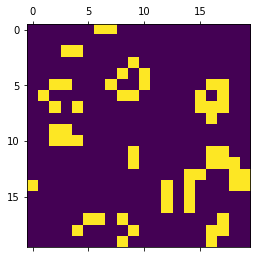

In [10]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states3);
HTML(anim.to_html5_video())

In [12]:
import sys
import numpy as np
import multiprocessing
import copy
                                                       

def live (start, end, current_state, n):  
    oct = []
    for step in range(start, end):
        x = step // n
        y = step % n
        alive = 0     
        cid = x*n+y
        for move in range (8):                                  
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                 
            alive +=  current_state[x1][y1]                                                                                  
        if (alive < 2 or alive > 3):                           
            state = 0                                             
        elif alive == 3:
            state = 1
        elif alive == 2:
            state = current_state[x][y]
        else:
            state = 0
        oct.append((x, y, state))    
    return oct                   


n = 20
steps = 20
current_state = copy.deepcopy(global_state)  
states4 = []
states4.append(copy.deepcopy(current_state))

xx = [1, 1, 1, -1, -1, -1, 0, 0]                                
yy = [1, -1, 0, 1, -1, 0, 1, -1]

chunks = 5
chunksize = n**2//chunks    
borders = [chunksize * i for i in range (chunks)]
borders.append(n**2)
args = [(borders[i-1], borders[i], current_state, n) for i in range(1, len(borders))]

pool = multiprocessing.Pool(multiprocessing.cpu_count())
for i in range(steps):
    results = pool.starmap(live, args)
    for oct in results:                                    # oct ce da sadrzi rezultat (x,y,novo stanje) za 8 celija
        for cell in oct:                                   # prolazimo celiju po celiju i dodajemo stanje na njene koordinate
            current_state[cell[0]][cell[1]] = cell[2]
    states4.append(copy.deepcopy(current_state))



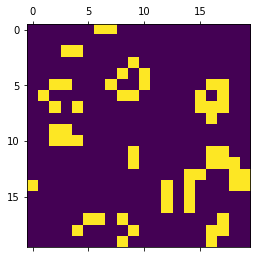

In [13]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states4);
HTML(anim.to_html5_video())